# Описание проекта
Мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г, и мы планируем кампанию на 2017-й

## Обзор данных

Импорт библиотек, настройки и выгрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

! pip install phik -q
import phik
from phik.report import plot_correlation_matrix

pd.set_option('display.max_columns', None)
np.set_printoptions(linewidth=110)
sns.set(rc={'figure.figsize':(19,10)})

### Описание данных

In [3]:
df.info()
df.sample(10, random_state=2007)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
1452,Marvel vs. Capcom 3: Fate of Two Worlds,PS3,2011.0,Fighting,0.81,0.28,0.11,0.14,84.0,7.3,T
15694,Gallop Racer Inbreed,PS2,2006.0,Sports,0.00,0.00,0.02,0.00,NaN,NaN,NaN
8625,Konami Krazy Racers,GBA,2001.0,Racing,0.09,0.03,0.04,0.00,78.0,tbd,E
1266,Rock Band 2,PS3,2008.0,Misc,1.13,0.20,0.00,0.16,91.0,7.9,T
85,The Sims 3,PC,2009.0,Simulation,0.99,6.42,0.00,0.60,86.0,7.6,T
13475,Wayne Gretzky's 3D Hockey '98,PS,1997.0,Sports,0.03,0.02,0.00,0.00,NaN,NaN,NaN
5466,Tak 2: The Staff of Dreams,GC,2004.0,Platform,0.26,0.07,0.00,0.01,75.0,8.6,E
14045,OutRun 2006: Coast 2 Coast,PSP,2006.0,Racing,0.03,0.01,0.00,0.00,82.0,8.1,E
5123,Destiny: The Taken King,PS3,2015.0,Shooter,0.17,0.11,0.02,0.06,NaN,5.5,T
16460,Young Justice: Legacy,X360,2013.0,Action,0.00,0.01,0.00,0.00,NaN,6.2,T


- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

### Проблемы?

- Неподходящее форматирование названий столбцов
- Пропуски в столбцах `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score` и `Rating`

Даты в DateTime переводить не будем. Нужен нам только год (подойдет и в таком формате), а DateTime сделает запись очень громоздкой

## Предобработка данных

Для начала разберемся с форматированием названий столбцов

In [6]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

И, наконец, посмотрим что там с пропусками. Без оценок и рейтингов

In [7]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Имеем 2 игры, практически без данных. Учитывая это строки удаляем

In [8]:
#df.drop(index=[659, 14244], inplace=True)
df.dropna(subset=['name'],inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Теперь можно подробно рассмотреть данные

In [9]:
sorted(df['name'].unique())

[' Beyblade Burst',
 ' Fire Emblem Fates',
 " Frozen: Olaf's Quest",
 ' Haikyu!! Cross Team Match!',
 ' Tales of Xillia 2',
 "'98 Koshien",
 '.hack//G.U. Vol.1//Rebirth',
 '.hack//G.U. Vol.2//Reminisce',
 '.hack//G.U. Vol.2//Reminisce (jp sales)',
 '.hack//G.U. Vol.3//Redemption',
 '.hack//Infection Part 1',
 '.hack//Link',
 '.hack//Mutation Part 2',
 '.hack//Outbreak Part 3',
 '.hack//Quarantine Part 4: The Final Chapter',
 '.hack: Sekai no Mukou ni + Versus',
 '007 Racing',
 '007: Quantum of Solace',
 '007: The World is not Enough',
 '007: Tomorrow Never Dies',
 '1 vs. 100',
 '1/2 Summer +',
 '10 Minute Solution',
 '100 All-Time Favorites',
 '100 Classic Books',
 '100 Classic Games',
 '1000 Cooking Recipes from ELLE à table',
 '1001 Touch Games',
 '101-in-1 Explosive Megamix',
 '101-in-1 Party Megamix Wii',
 '101-in-1 Sports Megamix',
 '101-in-1 Sports Party Megamix',
 '1080°: TenEighty Snowboarding',
 '11eyes: CrossOver',
 '12-Sai. Honto no Kimochi',
 '12-Sai. Koisuru Diary',
 '12Ri

In [10]:
df['name'].value_counts().unique()

array([12,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [11]:
df['name'].value_counts()

Need for Speed: Most Wanted                     12
Ratatouille                                      9
FIFA 14                                          9
LEGO Marvel Super Heroes                         9
Madden NFL 07                                    9
                                                ..
Teenage Mutant Ninja Turtles (3DS)               1
Machi-Ing Maker 3 x Tousouchuu                   1
Hanaoni: Koisomeru Koku - Eikyuu no Shirushi     1
Hiiro no Kakera: Shin Tamayori Hime Denshou      1
Frank Thomas Big Hurt Baseball                   1
Name: name, Length: 11559, dtype: int64

In [12]:
df[df['name'] == 'Need for Speed: Most Wanted']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1189,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1590,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1997,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2047,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3580,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5971,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6272,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6409,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


- Повторы в названиях могут быть связаны с выходом игры на разных платформах, в разные года в разных регионах, переизданиями и ремастерами.

In [13]:
np.asarray(sorted(df['platform'].unique()))

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG', 'N64', 'NES', 'NG', 'PC', 'PCFX',
       'PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype='<U4')

In [14]:
df[df['platform'] == 'GEN'].sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
831,NBA Jam,GEN,1992.0,Sports,1.75,0.25,0.00,0.05,NaN,NaN,NaN
1364,Disney's The Lion King,GEN,1994.0,Platform,0.97,0.37,0.03,0.05,NaN,NaN,NaN
12097,Street Fighter II': Special Champion Edition (...,GEN,1993.0,Action,0.00,0.00,0.07,0.00,NaN,NaN,NaN
8999,"Lunar 2: Eternal Blue(sales, but wrong system)",GEN,1994.0,Role-Playing,0.00,0.00,0.14,0.00,NaN,NaN,NaN
1841,NBA Jam Tournament Edition,GEN,1994.0,Sports,0.95,0.14,0.00,0.03,NaN,NaN,NaN


In [15]:
df[df['platform'] == 'GEN']['year_of_release'].unique()

array([1992., 1991., 1990., 1994., 1993.])

- Платформ много, в том числе очень старые и не слишком распространенные (или сильно локально), например `TG16`. Опираться на данные по ним будет сложно
- Какие-то обозначения, судя по всему объединяют несколько платформ (относится к релизам начала 1990г.), например `GEN`

<AxesSubplot:title={'center':'Количество релизов по годам'}, xlabel='Год выхода', ylabel='Количество релизов'>

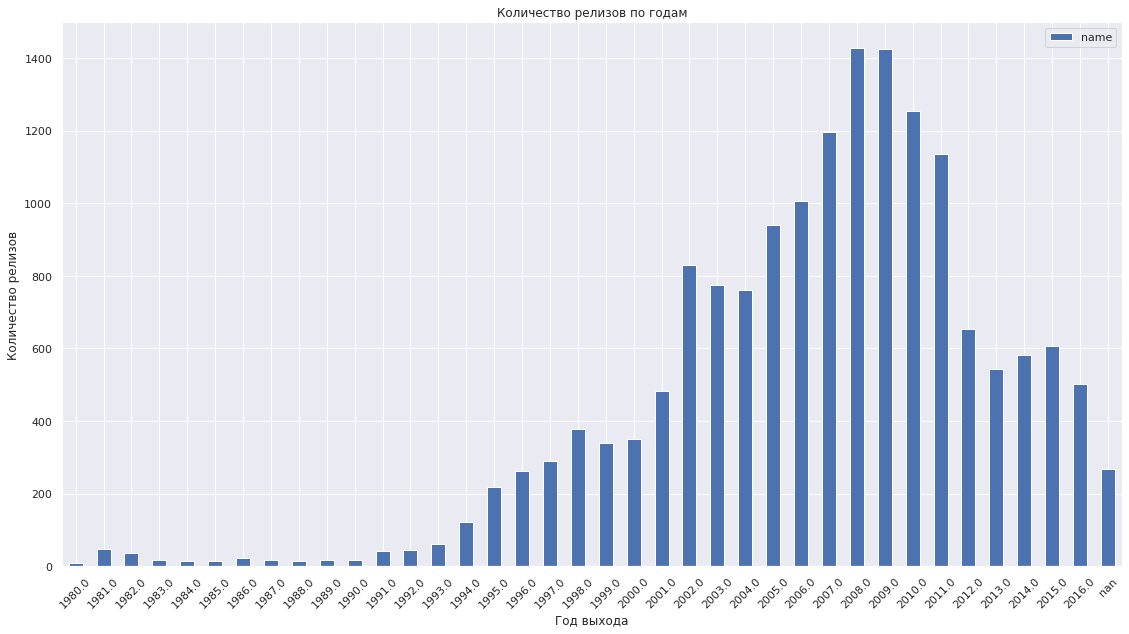

In [16]:
pivot = (df.groupby('year_of_release',dropna=False)['name']
         .agg('count')
         .reset_index())

pivot.plot(kind='bar',
           x='year_of_release',
           y='name',
           rot=45,
          title='Количество релизов по годам',
          xlabel='Год выхода',
          ylabel='Количество релизов')


In [17]:
df['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

<AxesSubplot:title={'center':'Продажи в регионе NA'}, xlabel='Год выхода', ylabel='Продажи'>

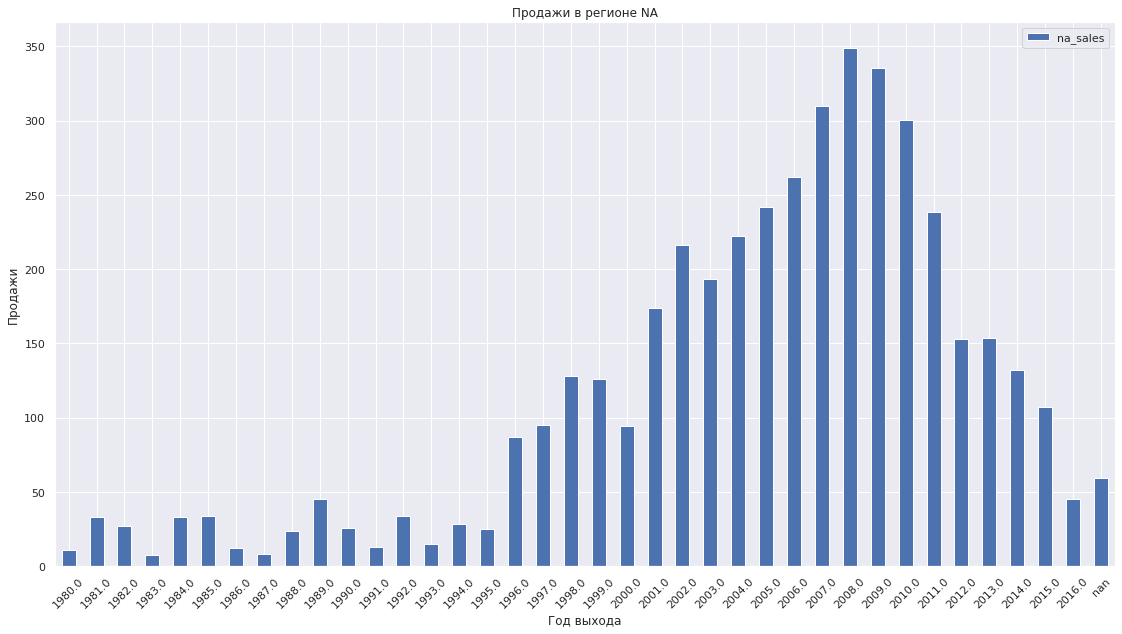

In [18]:
pivot = (df.groupby('year_of_release',dropna=False)['na_sales']
         .agg('sum')
         .reset_index())

pivot.plot(kind='bar',
           x='year_of_release',
           y='na_sales',
           rot=45,
          title='Продажи в регионе NA',
          xlabel='Год выхода',
          ylabel='Продажи')

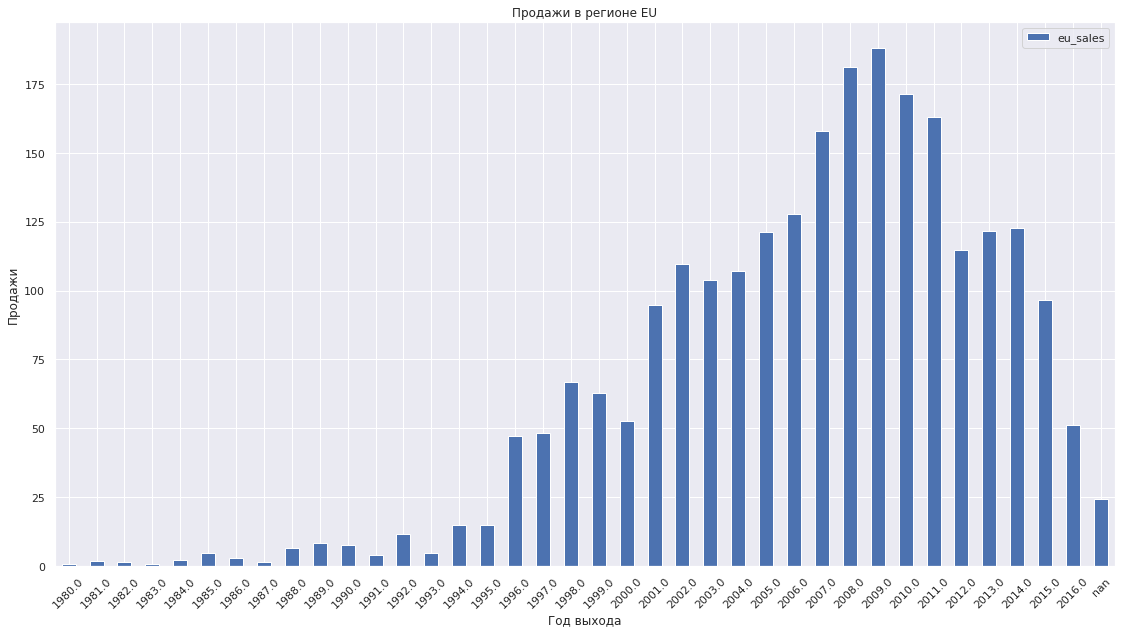

In [19]:
pivot = (df.groupby('year_of_release',dropna=False)['eu_sales']
         .agg('sum')
         .reset_index())

pivot.plot(kind='bar',
           x='year_of_release',
           y='eu_sales',
           rot=45,
          title='Продажи в регионе EU',
          xlabel='Год выхода',
          ylabel='Продажи');

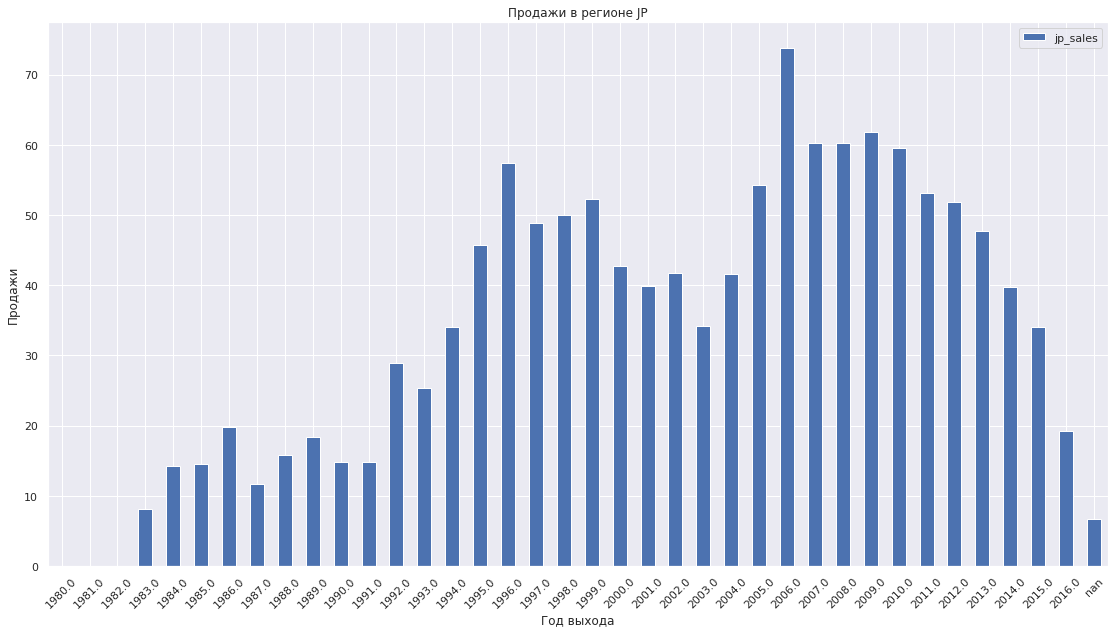

In [20]:
pivot = (df.groupby('year_of_release',dropna=False)['jp_sales']
         .agg('sum')
         .reset_index())

pivot.plot(kind='bar',
           x='year_of_release',
           y='jp_sales',
           rot=45,
          title='Продажи в регионе JP',
          xlabel='Год выхода',
          ylabel='Продажи');

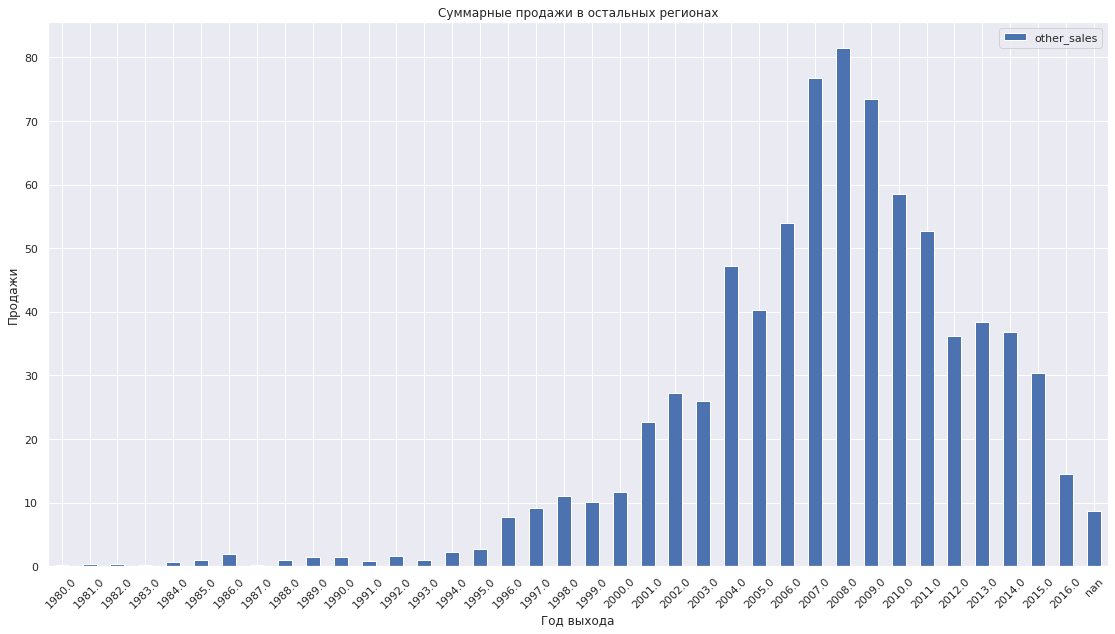

In [21]:
pivot = (df.groupby('year_of_release',dropna=False)['other_sales']
         .agg('sum')
         .reset_index())

pivot.plot(kind='bar',
           x='year_of_release',
           y='other_sales',
           rot=45,
          title='Суммарные продажи в остальных регионах',
          xlabel='Год выхода',
          ylabel='Продажи');

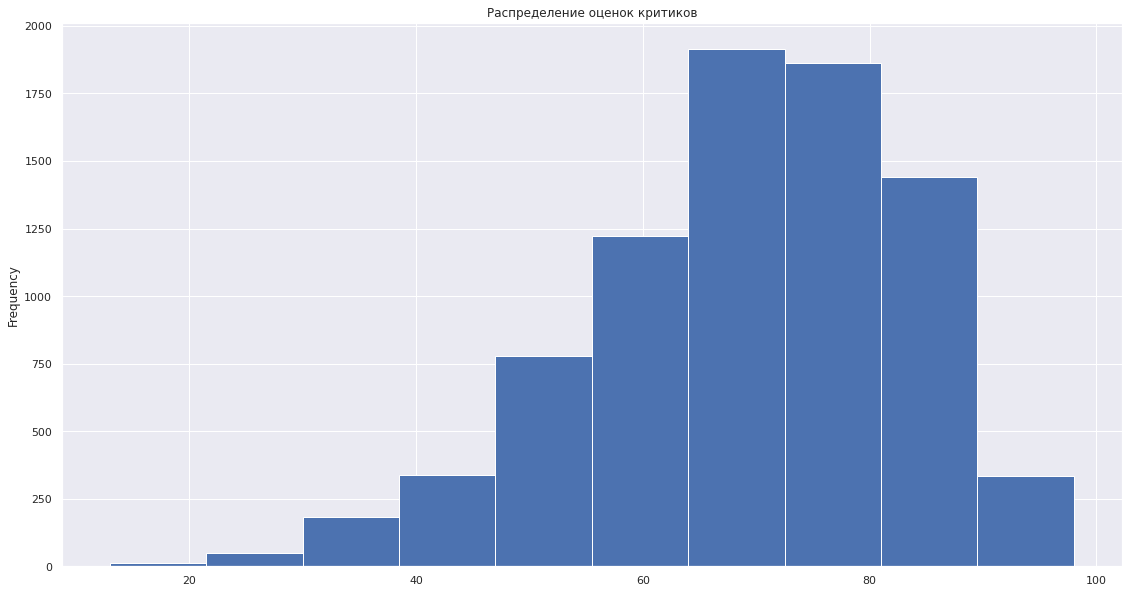

In [22]:
df['critic_score'].plot(kind='hist',title='Распределение оценок критиков');

In [23]:
df['critic_score'].isna().sum()

8576

In [24]:
df['critic_score'].fillna(-1,inplace=True)

In [25]:
np.asarray(df['user_score'].unique())

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4', '8.2', '9', '7.9', '8.1', '8.7',
       '7.1', '3.4', '5.3', '4.8', '3.2', '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8', '6.1', '6.7', '5.4', '4', '4.9',
       '4.5', '9.3', '6.2', '4.2', '6', '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7', '2.2', '2', '9.5', '2.1', '3.6',
       '2.8', '1.8', '3.8', '0', '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3', '0.5',
       '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [26]:
df['user_score'].isna().sum()

6699

Пропуски заполним -1. Это позволит не потерять их на этапе исследования

In [27]:
df[df['user_score']=='tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,-1.0,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,-1.0,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16693,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16695,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16696,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16702,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,-1.0,tbd,E


Можно найти, что аббревиатура tbd расшифровывается как to be determined т.е. "еще не определено" или "подлежит определению".

В нашем случае, учитывая, что она встречается в оценках и давно вышедших игр, следует интерпретировать ее как отсутствие информации, поэтому заменим такие оценки и пропуски на 0. Это позволит не потерять их на этапе исследования

После чего приведем столбец к числовому типу

In [28]:
df['user_score'].replace({'tbd':-1},inplace=True)

df['user_score'].fillna(-1,inplace=True)

(df['user_score']=='tbd').sum()

0

In [29]:
df['user_score'].isna().sum()

0

In [30]:
df['user_score'] = df['user_score'].astype('float')

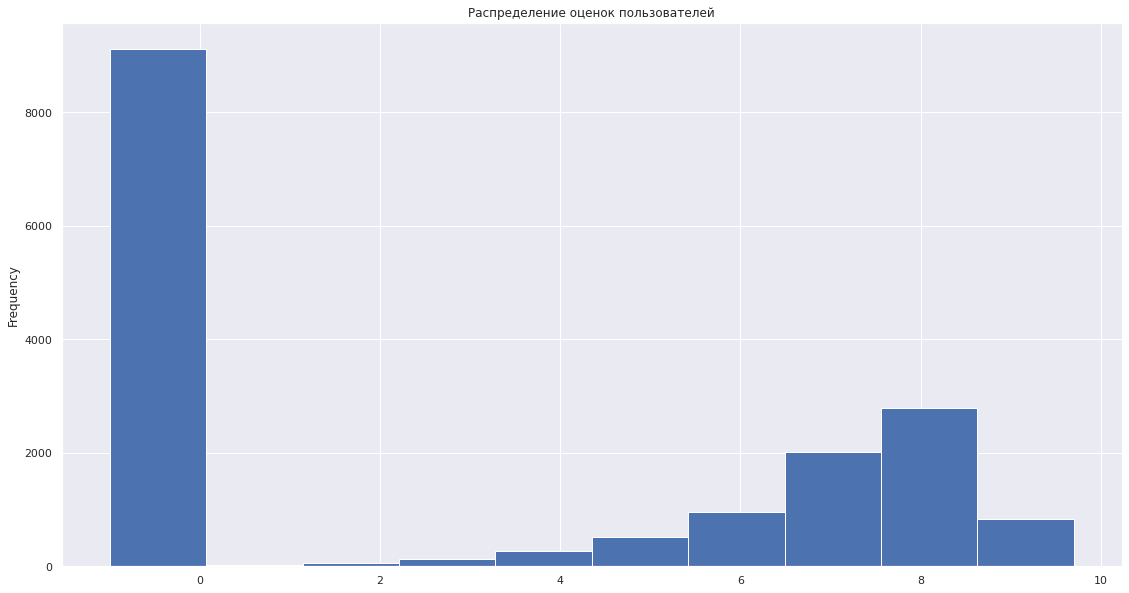

In [31]:
df['user_score'].plot(kind='hist', title='Распределение оценок пользователей');

In [32]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

В рейтингах присутствуют в том числе неактуальные на данный момент значения такие как K-A (Kids-Adult, заменен на E) и EC (Early Childhood, заменен на E).

Также nan и RP в целом можно указывают на одно и то же. В ожидании оценки и отсутствие оценки в нашем случае одно и то же.

Заменим значения в соответствии с актуальной системой оценки

In [33]:
df['rating'].replace({'K-A': 'E',
                      'EC': 'E'
                     }, inplace=True)

In [34]:
df['rating'].fillna('RP', inplace=True)

In [35]:
df['rating'].unique()

array(['E', 'RP', 'M', 'T', 'E10+', 'AO'], dtype=object)

In [36]:
# check
df['rating'].value_counts()

RP      6767
E       4001
T       2961
M       1563
E10+    1420
AO         1
Name: rating, dtype: int64

Посчитаем суммарные мировые продажи и добавим их в таблицу

In [37]:
df['world_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [38]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,RP,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,RP,31.38


In [39]:
df['year_of_release'].isna().sum()

269

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  float64
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
 11  world_sales      16713 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.5+ MB


In [41]:
df.dropna(subset=['year_of_release'],inplace=True)

In [42]:
df[['year_of_release','critic_score']] = df[['year_of_release','critic_score']].astype('int')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
 11  world_sales      16444 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB


## EDA

### Игры в год

Посмотрим количество вышедших игр по годам

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
total,9.0,46.0,36.0,17.0,14.0,14.0,21.0,16.0,15.0,17.0,16.0,41.0,43.0,60.0,121.0,219.0,263.0,289.0,379.0,338.0,350.0,482.0,829.0,775.0,762.0,939.0,1006.0,1197.0,1427.0,1426.0,1255.0,1136.0,653.0,544.0,581.0,606.0,502.0


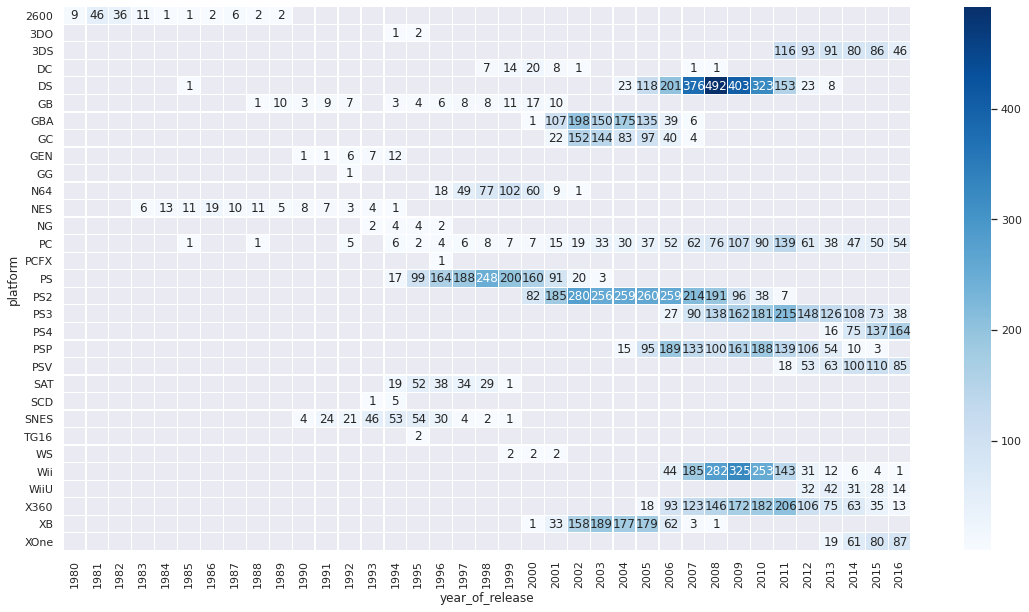

In [44]:
pivot = df.pivot_table(values='name',index='platform',columns='year_of_release',aggfunc='count',dropna=False)
pivot.loc[('total'), :] = pivot[pivot.index.get_level_values(0) != 'total'].sum() # Добавление суммарного количества игр в год

sns.heatmap(pivot.head(-1),
            annot=True,
            linewidth=.3,
            fmt='.0f',
            cmap='Blues')
plt.show
pivot.tail(1)

В таком виде смотреть не очень удобно, но можно увидеть, что и продажи и количество одновременно актуальных платформ примерно до 1995 года незначительно. И для предсказания они точно не пригодятся.

Чтобы удобнее было смотреть на данные отрежем совмем старые. За начало возьмем год появления PlayStation (1994)

year_of_release,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,,,
total,121.0,219.0,263.0,289.0,379.0,338.0,350.0,482.0,829.0,775.0,762.0,939.0,1006.0,1197.0,1427.0,1426.0,1255.0,1136.0,653.0,544.0,581.0,606.0,502.0


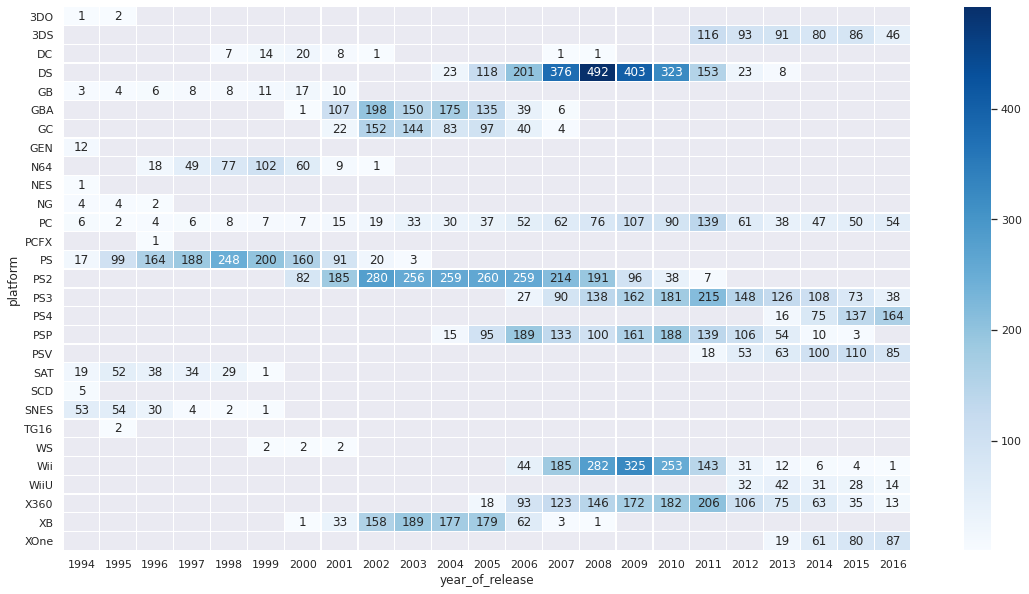

In [45]:
df_20yr = df.query('year_of_release >= 1994')

pivot = df_20yr.pivot_table(values='name',
                            index='platform',
                            columns='year_of_release',
                            aggfunc='count',
                           dropna=False)

pivot.loc[('total'), :] = pivot[pivot.index.get_level_values(0) != 'total'].sum() # Добавление суммарного количества игр в год

sns.heatmap(pivot.head(-1),
            annot=True,
            linewidth=.3,
            fmt='.0f',
            cmap="Blues")

plt.show
pivot.tail(1)

#### Вывод

Так смотреть гораздо удобнее и можно заметить:
- Популярные платформы "***живут***" 10-12 лет и остаются популярными (большое кол-во релизов) в течение 8-10 лет
- Самыми плодовитыми (что тоже может говорить о популярности) платформами являются DS, 3DS, GBA, PSP, PSV среди портативных и PlayStation (все поколения), Wii, Xbox (тоже все поколения, несмотря на просадку XOne) среди стационарных
- Подъемом индустрии можно считать период с 2006 по 2011 год. Тогда в течение года выходило более 1000 тайтлов.
- За подъемом следует заметный спад (более 30%)
- На момент составления датасета актуальными и популярными можно считать PS4, PSV, PC и XOne. (количество релизов растет, с учетом возможной неполноты данных за 2016 год) 

### Игры по платформам

Посмотрим теперь на суммарные продажи по платформам

year_of_release,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,,,
total,79.23,88.12,199.15,201.07,256.31,251.11,201.66,331.46,394.97,357.54,418.68,457.82,517.71,604.75,671.5,658.82,590.13,507.58,355.84,361.24,331.53,267.98,129.94


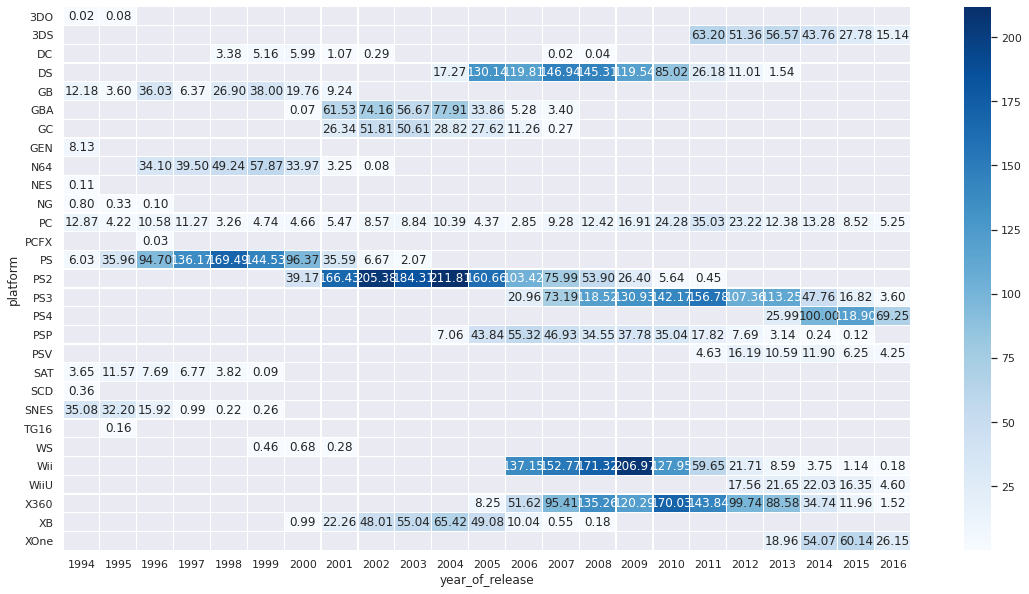

In [46]:
pivot = df_20yr.pivot_table(values='world_sales',
                            index='platform',
                            columns='year_of_release',
                            aggfunc='sum',
                           dropna=False)

pivot.loc[('total'), :] = pivot[pivot.index.get_level_values(0) != 'total'].sum() # Добавление продаж в год

sns.heatmap(pivot.head(-1),
            annot=True,
            linewidth=.3,
            fmt='.2f',
            cmap='Blues')
plt.show
pivot.tail(1)

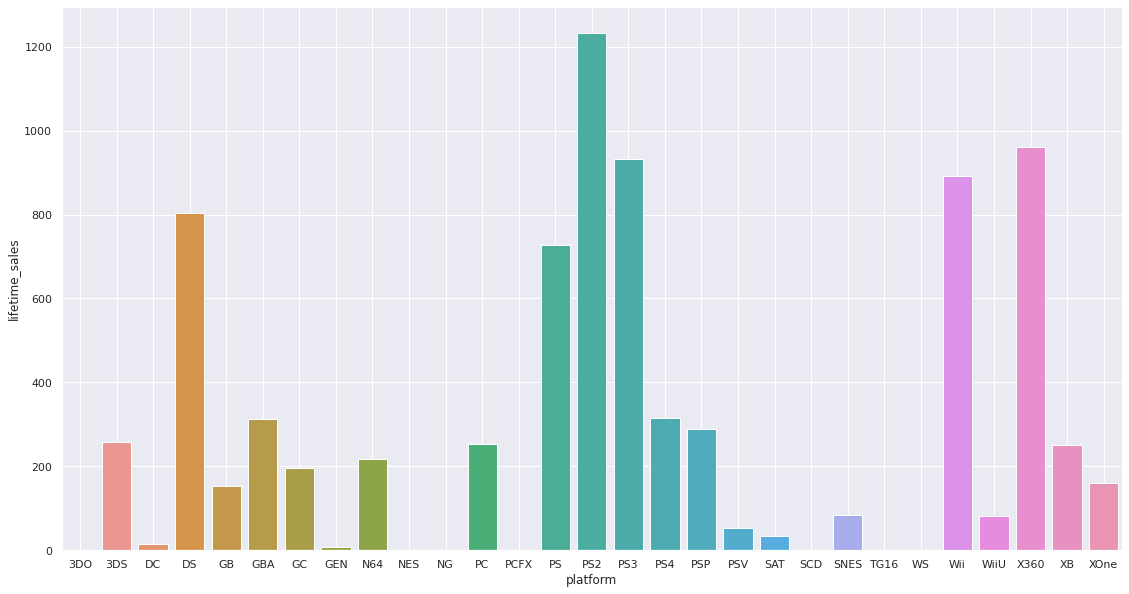

In [47]:
pivot['lifetime_sales'] = pivot.apply('sum',axis=1)

pivot.reset_index(inplace=True)

sns.barplot(data=pivot.head(-1),
            x='platform',
            y='lifetime_sales')

plt.grid(True)

#### Вывод

Данные о продажах подтверждают выводы, сделанные на обзоре кол-ва релизов.

Можно добавить, что ***начиная с 2-3 и по 6-8 год жизни платформы продажи на популярных максимальны***, это может быть полезно для составления прогноза

### Актуальный период появляется здесь

Для разработки рекомендаций на 2017 год возьмем данные за последние 3 (2014-2016)

Это позволит проследить тенденцию, этап жизни платформы и изменение ее популярности даже с учтом неполноты данных за 2016 год. В случае сомнений можно смотреть тренд 14-15 годов.

In [48]:
df_=df.query('year_of_release >= 2014')
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   int64  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     1689 non-null   int64  
 9   user_score       1689 non-null   float64
 10  rating           1689 non-null   object 
 11  world_sales      1689 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 171.5+ KB


В выбранном периоде осталось 1689 тайтлов, но около половины оценок от критиков и игроков отстутствуют

year_of_release,2014,2015,2016
platform,,,
total,331.53,267.98,129.94


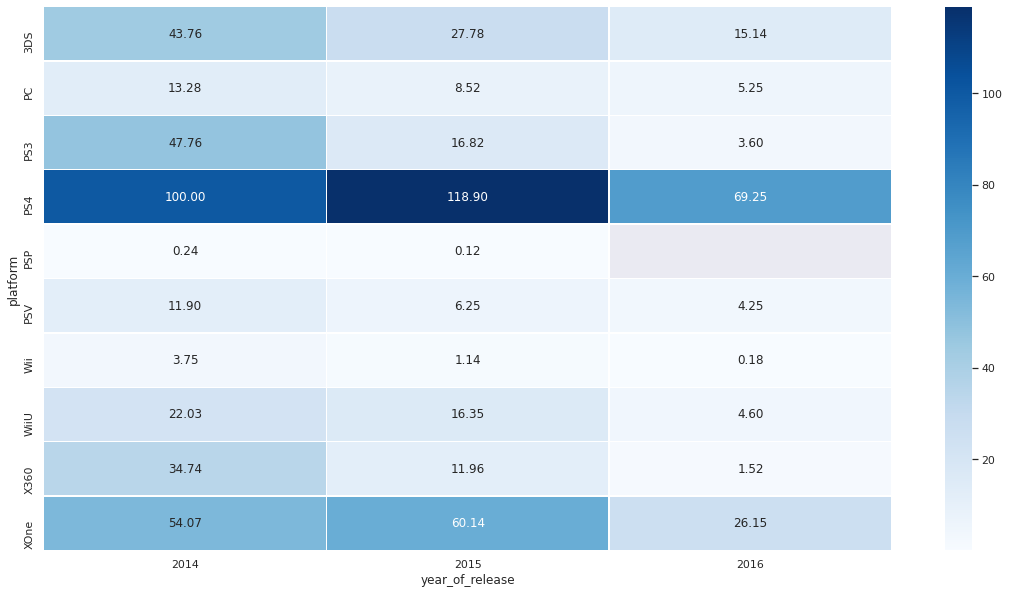

In [49]:
pivot = df_.pivot_table(values='world_sales',
                        index='platform',
                        columns='year_of_release',
                        aggfunc='sum',
                       dropna=False)

pivot.loc[('total'), :] = pivot[pivot.index.get_level_values(0) != 'total'].sum()

sns.heatmap(pivot.head(-1),
            annot=True,
            linewidth=.3,
            fmt='.2f',
            cmap='Blues')
plt.show
pivot.tail(1)

year_of_release,2014,2015,2016
platform,,,
total,581.0,606.0,502.0


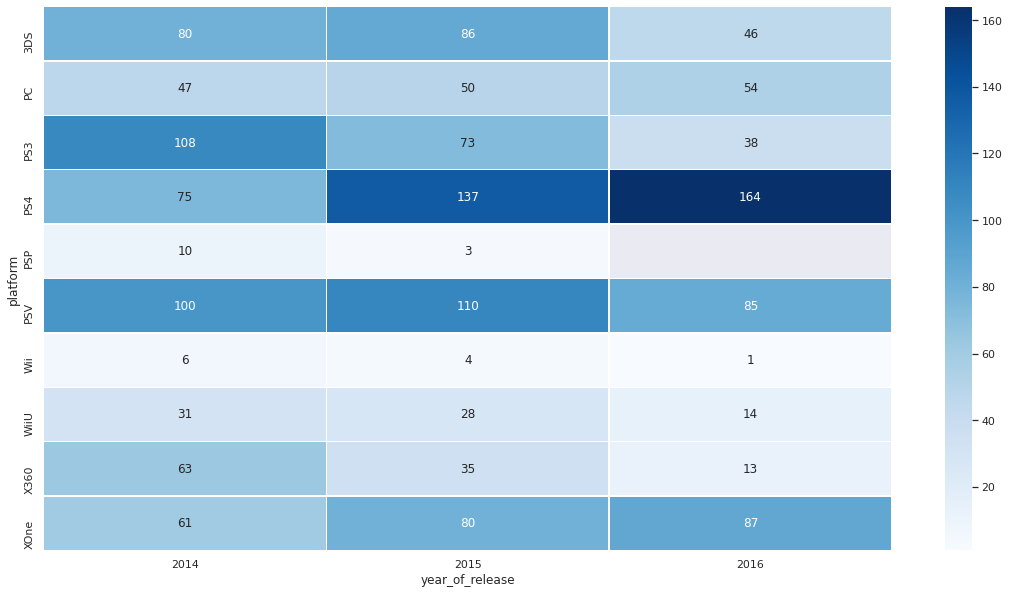

In [50]:
pivot = df_.pivot_table(values='name',
                         index='platform',
                         columns='year_of_release',
                         aggfunc='count',
                       dropna=False)

pivot.loc[('total'), :] = pivot[pivot.index.get_level_values(0) != 'total'].sum()

sns.heatmap(pivot.head(-1),
            annot=True,
            linewidth=.3,
            fmt='.0f',
            cmap="Blues")
plt.show
pivot.tail(1)

Также посмотрим среднюю выручку с 1 игры

year_of_release,2014,2015,2016
platform,,,
XOne,0.886393,0.75175,0.300575


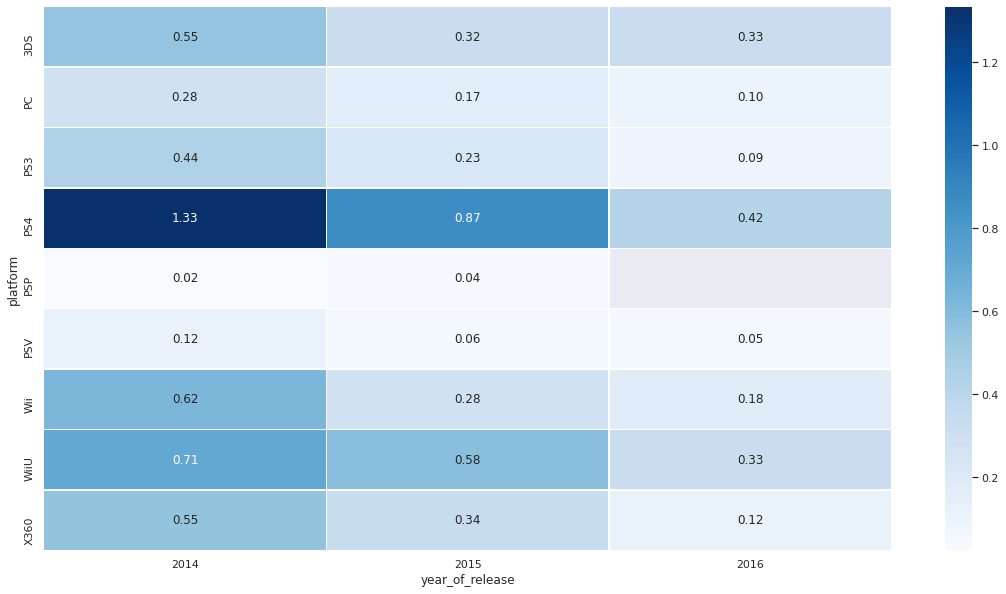

In [51]:
pivot = df_.pivot_table(values='world_sales',
                         index='platform',
                         columns='year_of_release',
                         aggfunc='mean',
                       dropna=False)

sns.heatmap(pivot.head(-1),
            annot=True,
            linewidth=.3,
            fmt='.2f',
            cmap="Blues")
plt.show
pivot.tail(1)

Можно заметить, что несмотря, на рост количества релизов суммарные и средние продажи падают. 

Возможно это связано с изменением политики компаний, которые вместо небольшого количества долгих и дорогих (как в разработке так и потом в магазине) игр в пользу бОльшего количества средних или маленьких игр. 

Затрат на производство и производственный цикл меньше, а значит меньше и рисков. Стратегия схожая со стратегией многих венчурных инвестиционных фондов

Но не стоит исключать и возможный кризис индустрии

Популярными, потенциально прибыльными и, значит, интересными нам платформами можно назвать PS4, XOne, WiiU и 3DS.

- PS4, XOne актуальные и популярные платформы в середине жизненного цикла.

Интересными с оговорками можно назвать 3DS и WiiU.
- 3DS, определенно, популярна, но срок жизни явно уже перевалил за середину
- WiiU молодая платформа, не получившая большой популярности

In [52]:
platforms = df_.platform.unique()
platforms

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV', 'PSP'], dtype=object)

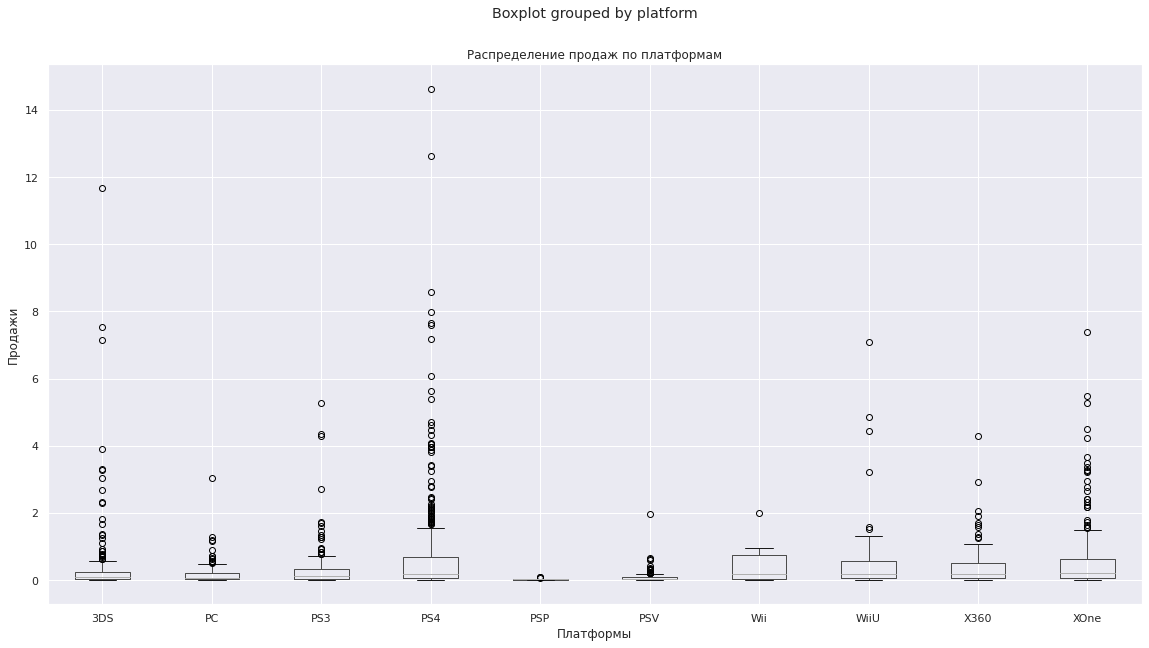

In [53]:
df_.boxplot(column='world_sales',by='platform')

plt.title('Распределение продаж по платформам')
plt.ylabel('Продажи')
plt.xlabel('Платформы');

Text(0.5, 0, 'Платформы')

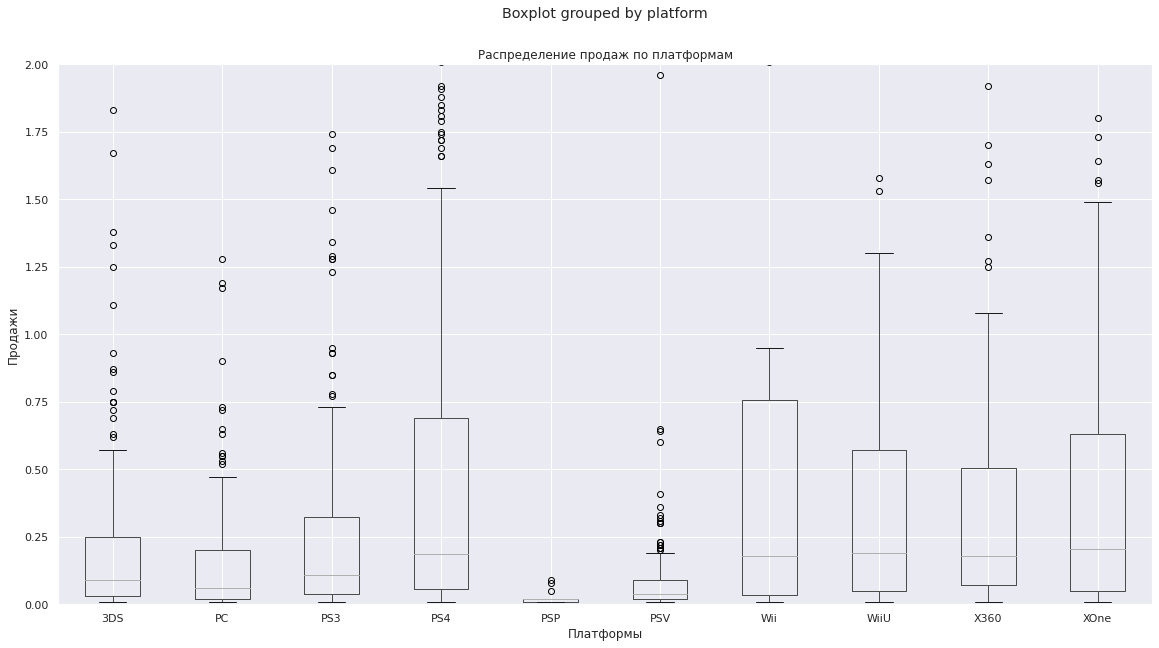

In [54]:
df_.boxplot(column='world_sales', by='platform').set_ylim([0, 2])

plt.title('Распределение продаж по платформам')
plt.ylabel('Продажи')
plt.xlabel('Платформы')

Из интересного
- Медианы для PS4, XOne, Wii и WiiU примерно равны.
- У них же и самы большие "ящики". Это может говорить и бОльшей привлекательности в плане рекламы
- Если поиграться с масштабом графика будет видно, что продажи на PS4 содержат довольно большое количество выбросов, значит больше вероятность "нарваться" на сверхприбыльный проект.
- Также довольно много выбросов у 3DS, но многие из них попадают в диапазон "нормы" PS4


### Влияние отзывов на продажи

Посмотрим как влияют отзывы на продажи в рамках платформы. Смотреть будем на PS4, XOne, WiiU и 3DS.

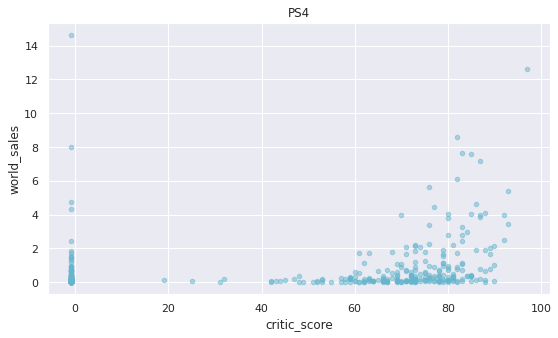

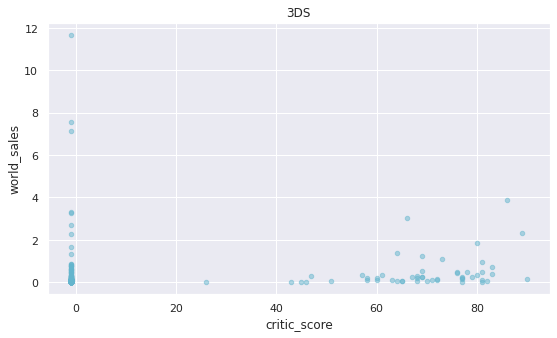

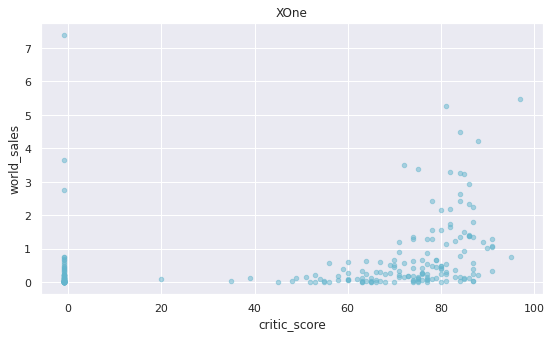

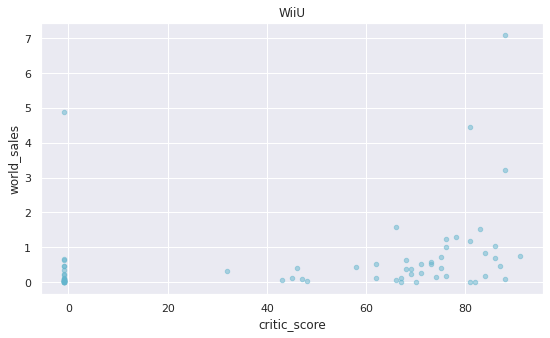

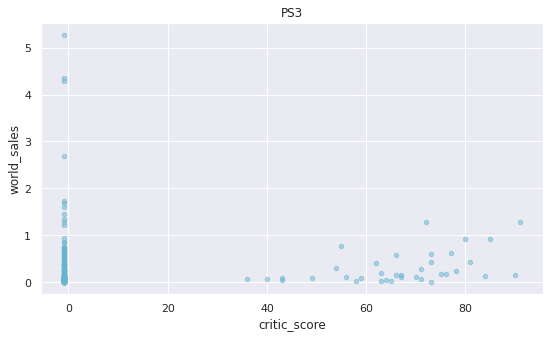

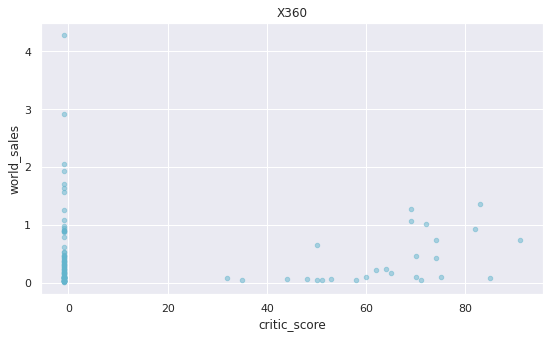

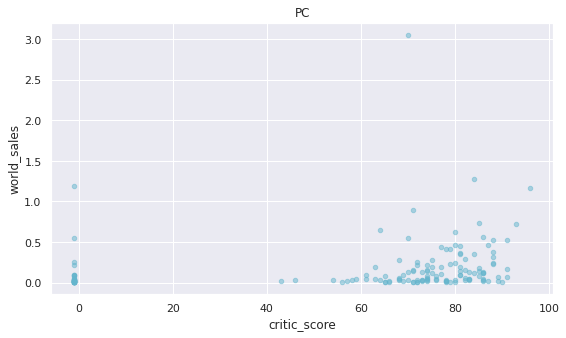

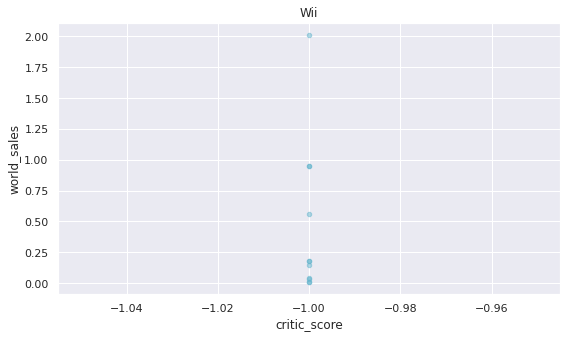

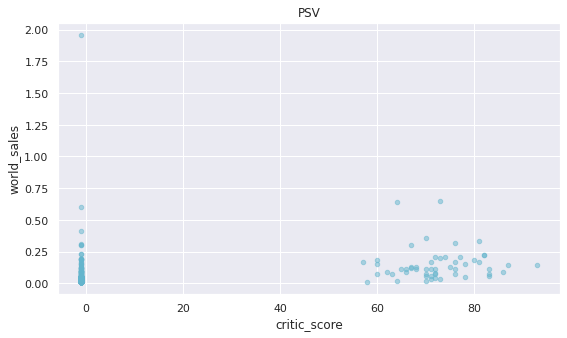

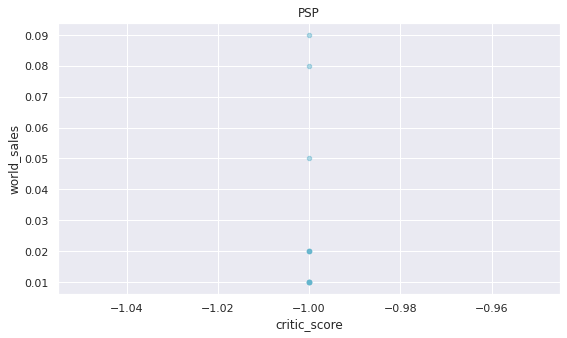

In [55]:
platforms = df_.platform.unique()

for x in platforms:
    (df_.query('platform == @x')
     .plot(kind='scatter',
           x='critic_score',
           y='world_sales',
           c='c',
           title=x,
           alpha=.5,
           figsize=(9,5)))

И то же самое по отзывам игроков

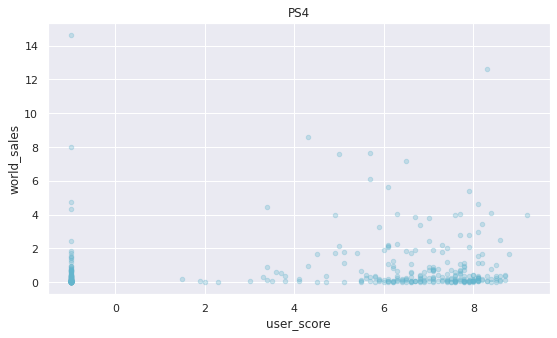

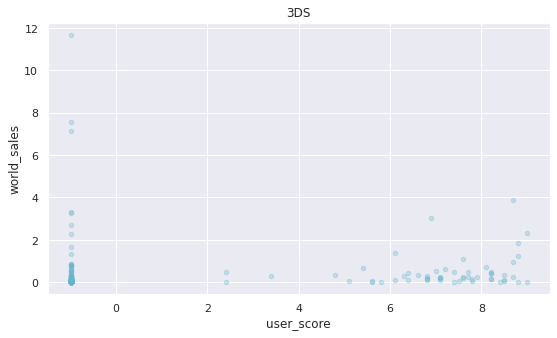

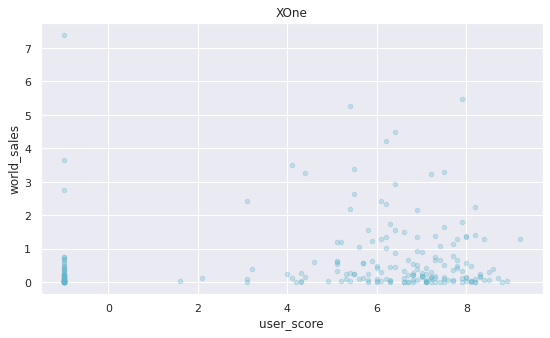

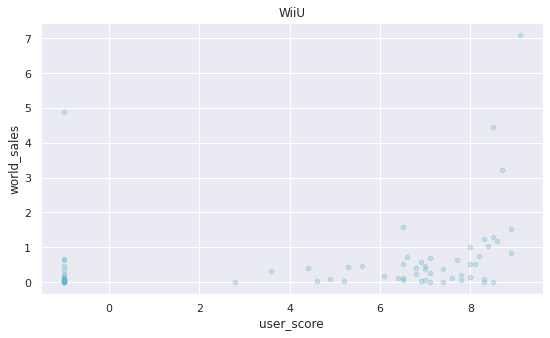

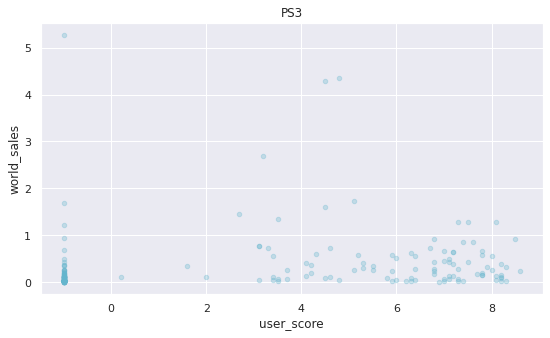

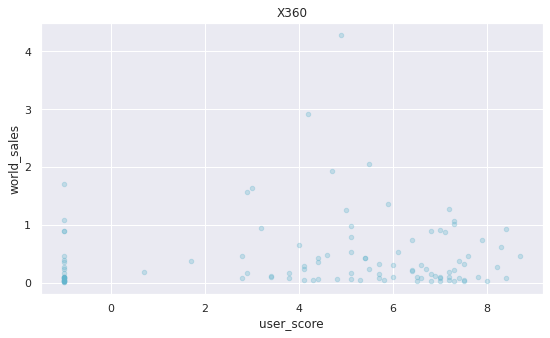

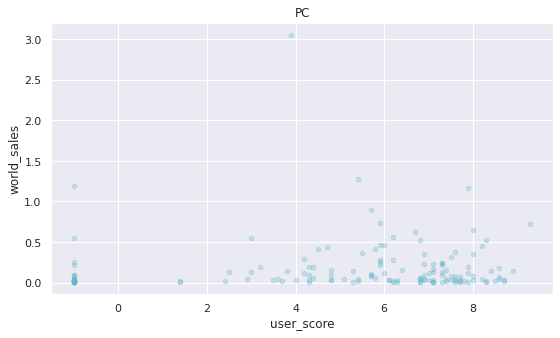

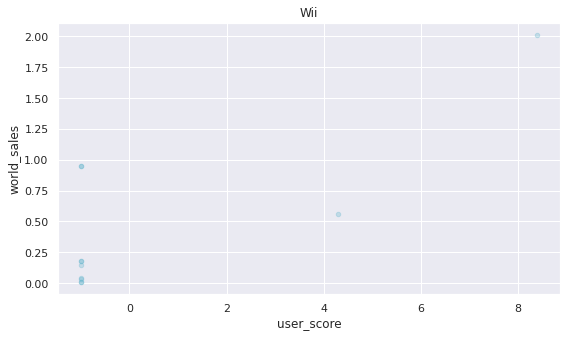

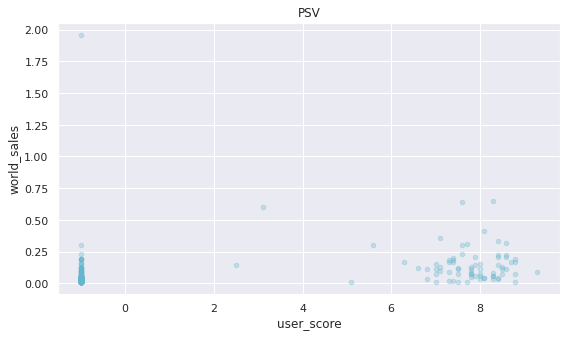

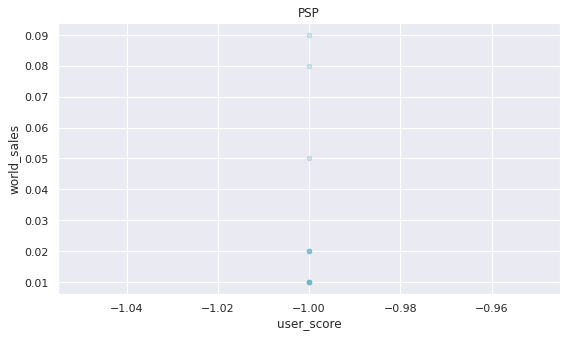

In [56]:
for x in platforms:
    (df_.query('platform == @x')
     .plot(kind='scatter',
           x='user_score',
           y='world_sales',
           c='c',
           title=x,
           alpha=.3,
           figsize=(9,5)))

#### Вывод

Интереснее смотреть на PS4 и XOne (там данных больше).

- Игроки могут ставить низкие оценки или не ставить вовсе, но продажи остаются на высокм уровне
- Когда критики ставят оценки выше 75 пунктов у игры очень неплохие шансы продаться больше, а может и наоборот. Однозначного вывода сделать нельзя

### Корреляции

Посчитаем корреляцию

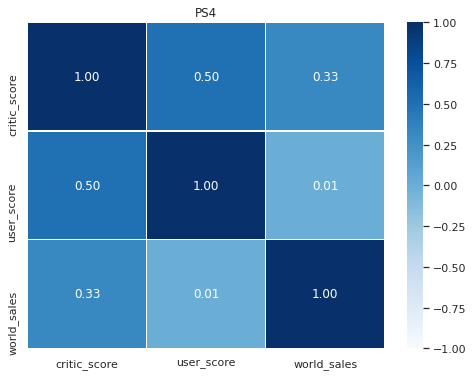

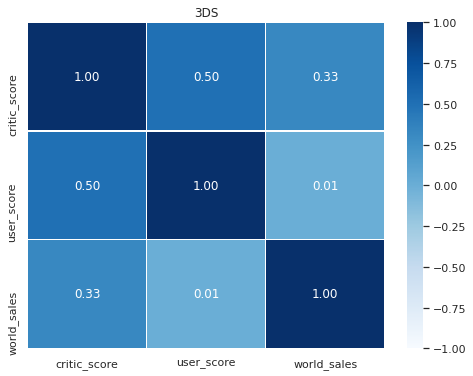

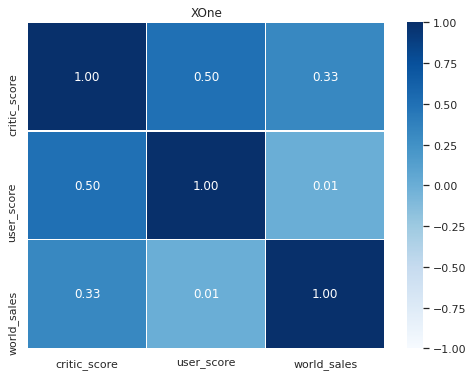

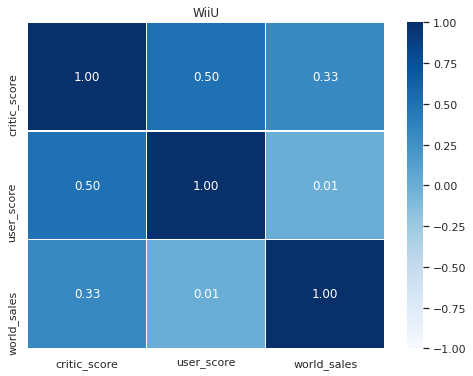

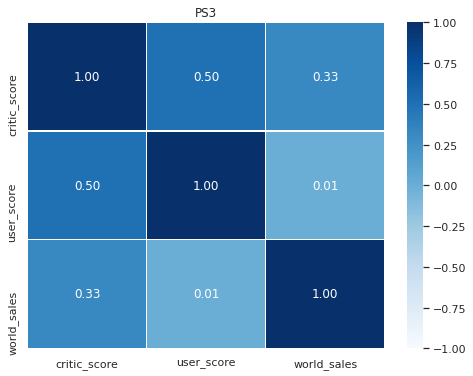

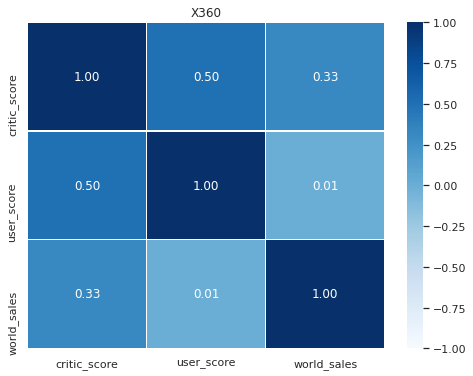

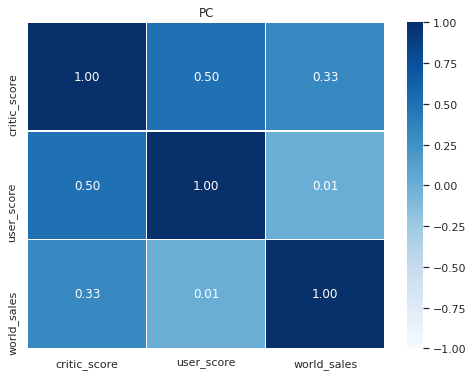

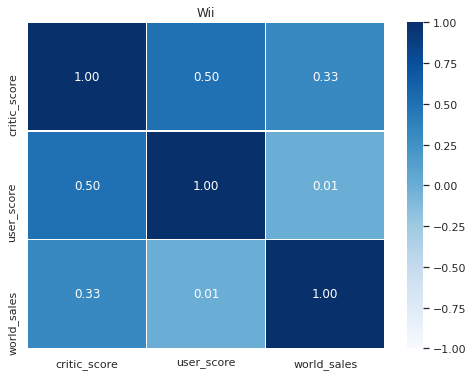

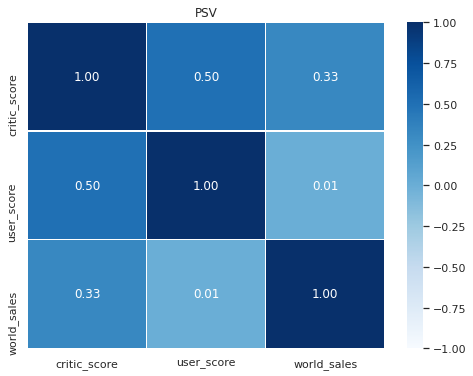

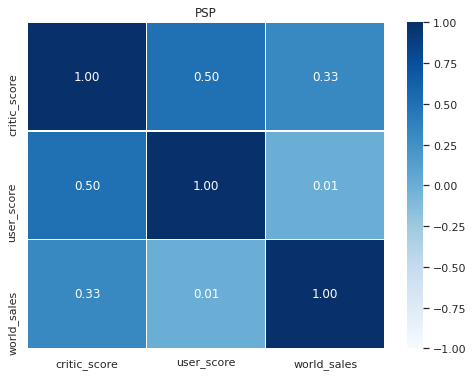

In [57]:
sns.set(rc={'figure.figsize':(8,6)})
cols= ['critic_score', 'user_score', 'rating', 'world_sales']
df_for_corr = df_.query('critic_score>0 and user_score>0')[cols]

for x in platforms:
    sns.heatmap(df_for_corr.corr(), 
                annot=True, 
                linewidth=.3,
                fmt='.2f',
                cmap="Blues",
                vmax=1,
                vmin=-1
                )
    plt.title(x)
    plt.show()

Коэффицент корреляции Пирсона не показывает линейной связи

Попробуем проверить корреляцию по коэффиценту Фика

In [59]:
phik_overview = df_.phik_matrix()

interval columns not set, guessing: ['year_of_release', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'world_sales']


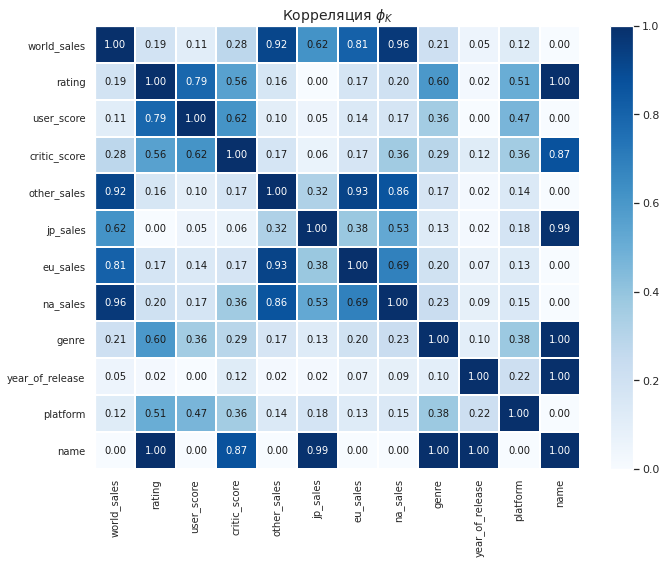

In [60]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, 
                        vmax=1, 
                        color_map="Blues", 
                        title=f"Корреляция $\phi_K$", 
                        figsize=(10, 8))

Фик, тоже не показал ничего интересного. Разве что можно проранжировать вклад разных регионов в мировые продажи

1. NA
2. Other
3. EU
4. JP

### Продажи по жанрам

In [61]:
pivot=df_.pivot_table(columns='genre',
                     index='year_of_release',
                     values='world_sales',
                     aggfunc='sum')

In [62]:
pivot

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
year_of_release,,,,,,,,,,,,
2014,97.23,5.57,15.85,23.38,8.81,1.49,16.66,45.62,65.21,5.58,45.15,0.98
2015,72.02,8.16,7.90,11.57,6.05,0.71,8.07,37.64,67.51,5.66,40.84,1.85
2016,30.11,3.82,4.47,2.60,3.23,0.01,2.79,18.18,38.22,1.89,23.49,1.13


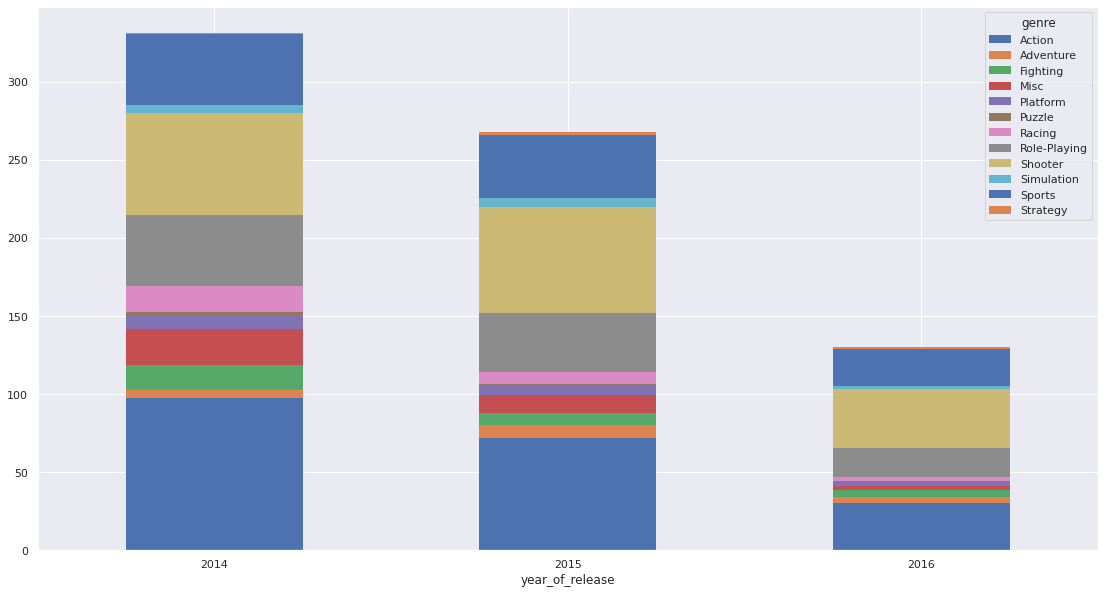

In [63]:
sns.set(rc={'figure.figsize':(19,10)})

pivot.plot.bar(stacked=True,linewidth=0)
plt.xticks(rotation=0);

#### Вывод
Хорошо видно, что самые популярные жанры это Action, Shooter, Sports и Role-Playing.

Если и делать ставку то на игры этих жанров

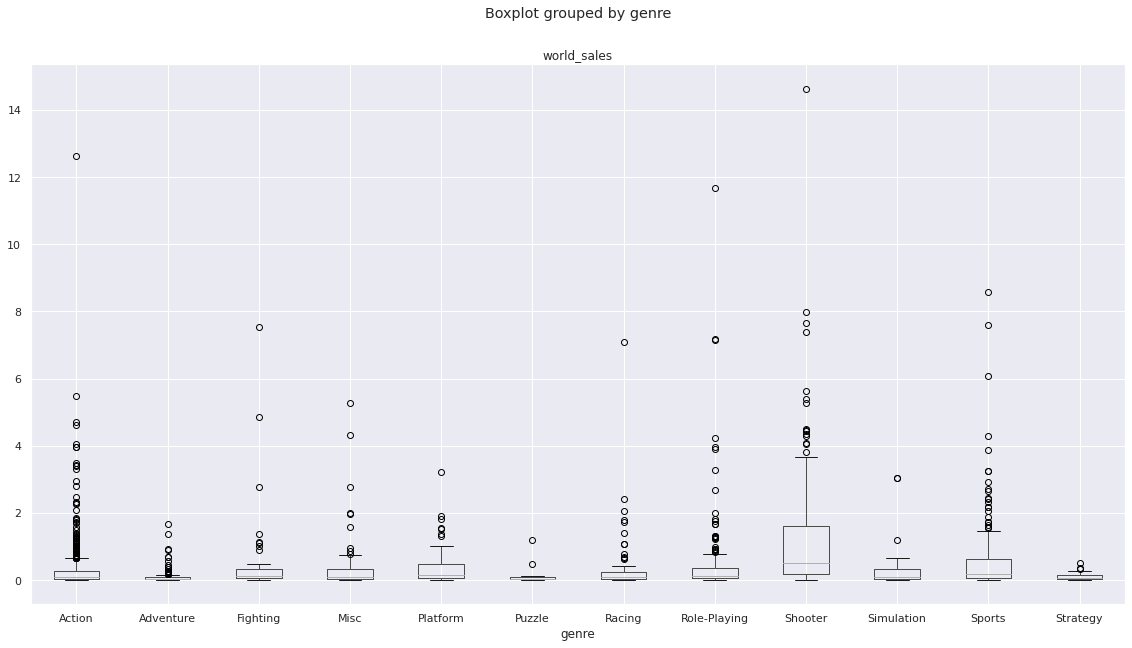

In [64]:
df_.boxplot(column='world_sales',by='genre');

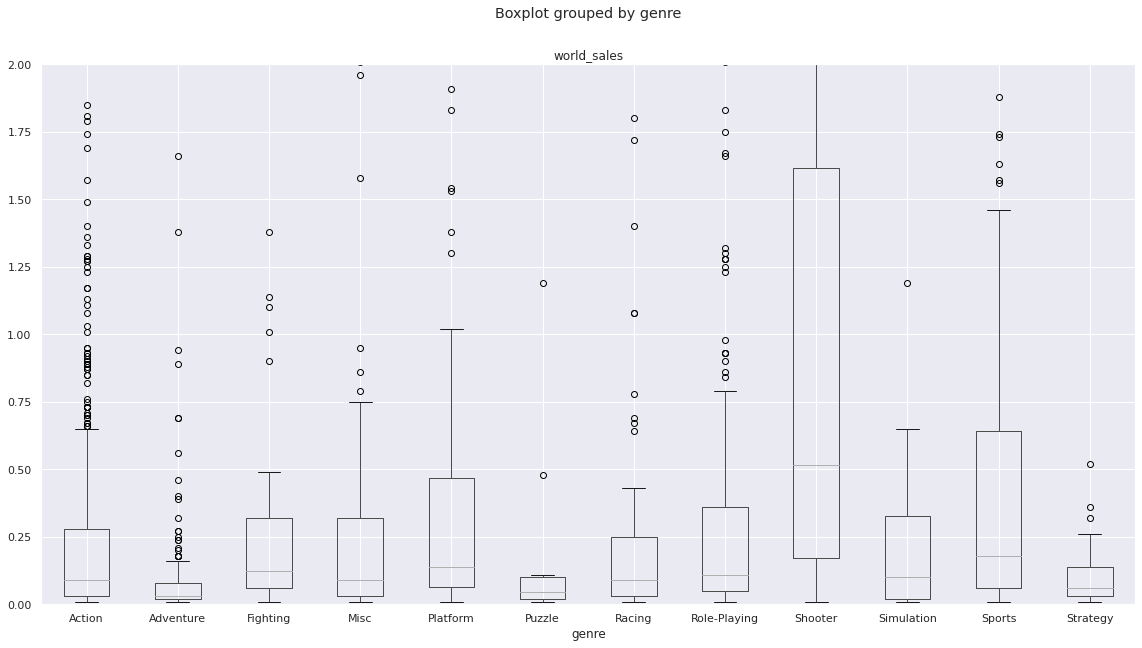

In [65]:
df_.boxplot(column='world_sales',by='genre')
plt.ylim(0,2);

По диаграммам размаха видно:
- Самые большие медианы у Shooter, Sports, Platform, Action
- Самый большие "ящики" у Shooter, Sports и Platform

## Портреты пользователей по регионам

In [66]:
pivot = df_[['genre','na_sales','eu_sales','jp_sales']]
pivot = pivot.groupby('genre').agg('sum')
pivot

,na_sales,eu_sales,jp_sales
genre,,,
Action,72.53,74.68,29.58
Adventure,5.64,6.49,3.60
Fighting,12.43,6.69,6.37
Misc,15.05,12.86,5.61
Platform,6.79,6.80,2.69
Puzzle,0.65,0.52,0.93
Racing,8.74,14.13,1.76
Role-Playing,33.47,28.17,31.16
Shooter,79.02,65.52,4.87


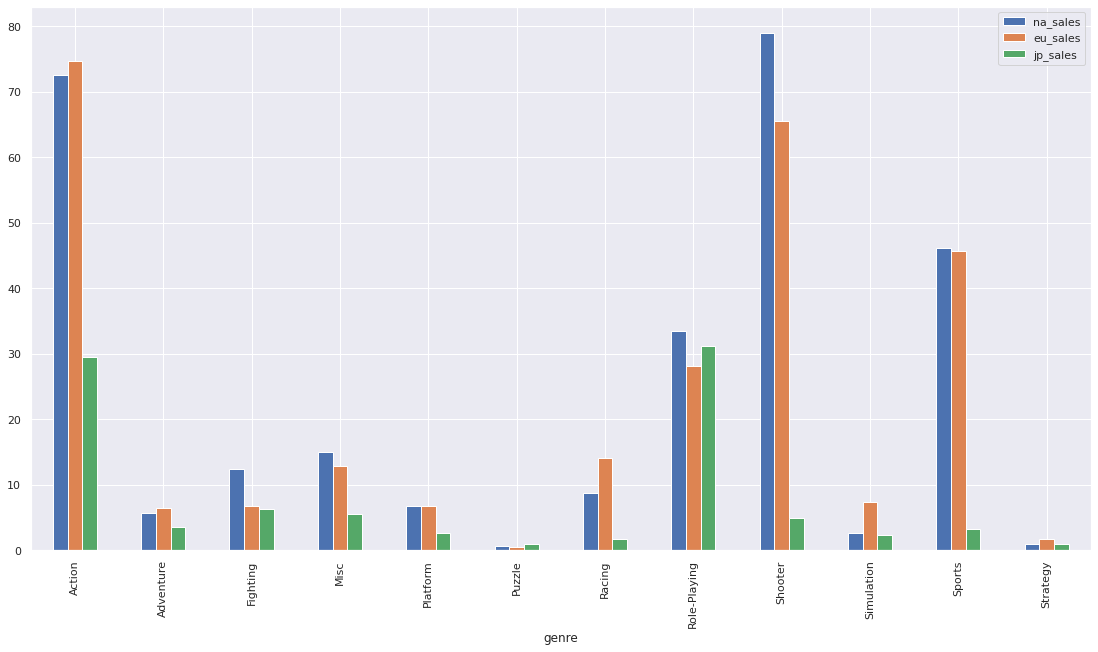

In [67]:
pivot.plot.bar();

In [68]:
# check
pivot

,na_sales,eu_sales,jp_sales
genre,,,
Action,72.53,74.68,29.58
Adventure,5.64,6.49,3.60
Fighting,12.43,6.69,6.37
Misc,15.05,12.86,5.61
Platform,6.79,6.80,2.69
Puzzle,0.65,0.52,0.93
Racing,8.74,14.13,1.76
Role-Playing,33.47,28.17,31.16
Shooter,79.02,65.52,4.87


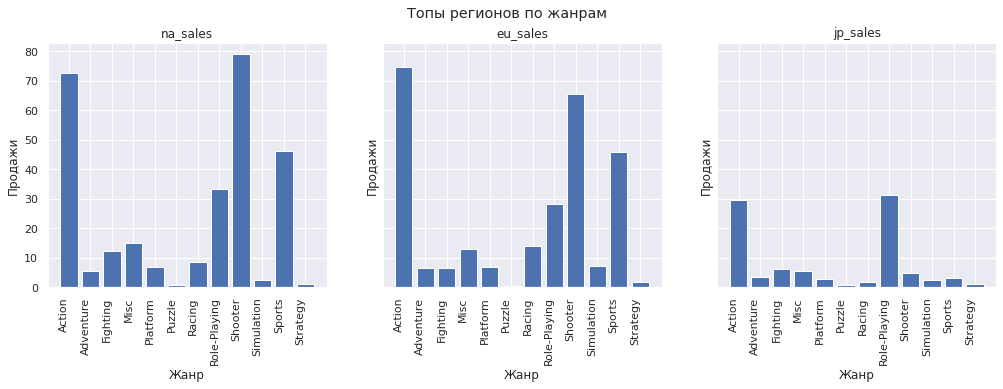

In [69]:
f, axs = plt.subplots(1,3, figsize=(17, 5), sharey=True)
f.autofmt_xdate(rotation=90)


axs[0].bar(x=pivot.index, height=pivot['na_sales'])
axs[0].grid(True)
axs[0].set_title('na_sales')
axs[0].set_xlabel('Жанр')
axs[0].set_ylabel('Продажи')

axs[1].bar(x=pivot.index, height=pivot['eu_sales'])
axs[1].grid(True)
axs[1].set_title('eu_sales')
axs[1].set_xlabel('Жанр')
axs[1].set_ylabel('Продажи')

axs[2].bar(x=pivot.index, height=pivot['jp_sales'])
axs[2].grid(True)
axs[2].set_title('jp_sales')
axs[2].set_xlabel('Жанр')
axs[2].set_ylabel('Продажи')

plt.suptitle('Топы регионов по жанрам');

***Портреты***(топ жанров)***:***

*NA*
1) Shooter 2) Action 3) Sports 4) Role-Playing

*EU*
1) Action 2) Shooter 3) Sports 4) Role-Playing

*JP*
1) Role-Playing 2) Action 3) Fighting 4) Misc


**Европейские** и **американские** игроки в целом ведут себя одинаково (разве что пострелять американцы любят чуть больше).

**Японцы** же отличаются существенно. 
- Спортивные игры тут совсем не в почете
- В топ попали игры жанра Misc, что может значить как смешение жанров так и невозможность определить принадлежность к конкретному из-за сильной специфичности игры (Азиатские игровые рынки этим славятся)
- Ролевые игры на вершине "хит-парада", но есть одно "но":
 - В ролевые игры судя по всему входят не только классические RPG но и JRPG, а это сильно специфическая история и популярны они как раз на рынках Азии. Ситуация, думаю, повторяет описанное в предыдущем пункте, разве что для JRPG есть собственное назнание и относят их к ролевым. Поэтому считаю, что в случае с JP-игроками нужно считать это именно продажами JRPG, они точно дают основной вклад. Особенно сравнивая с соотношением продаж жанра Action.

In [70]:
pivot = df_[['platform','na_sales','eu_sales','jp_sales']]
pivot = pivot.groupby('platform').agg('sum')
pivot

,na_sales,eu_sales,jp_sales
platform,,,
3DS,22.64,16.12,44.24
PC,7.23,17.97,0.00
PS3,22.05,25.54,11.22
PS4,98.61,130.04,15.02
PSP,0.00,0.00,0.36
PSV,2.52,3.53,14.54
Wii,2.08,2.59,0.00
WiiU,19.36,13.15,7.31
X360,28.30,15.49,0.08


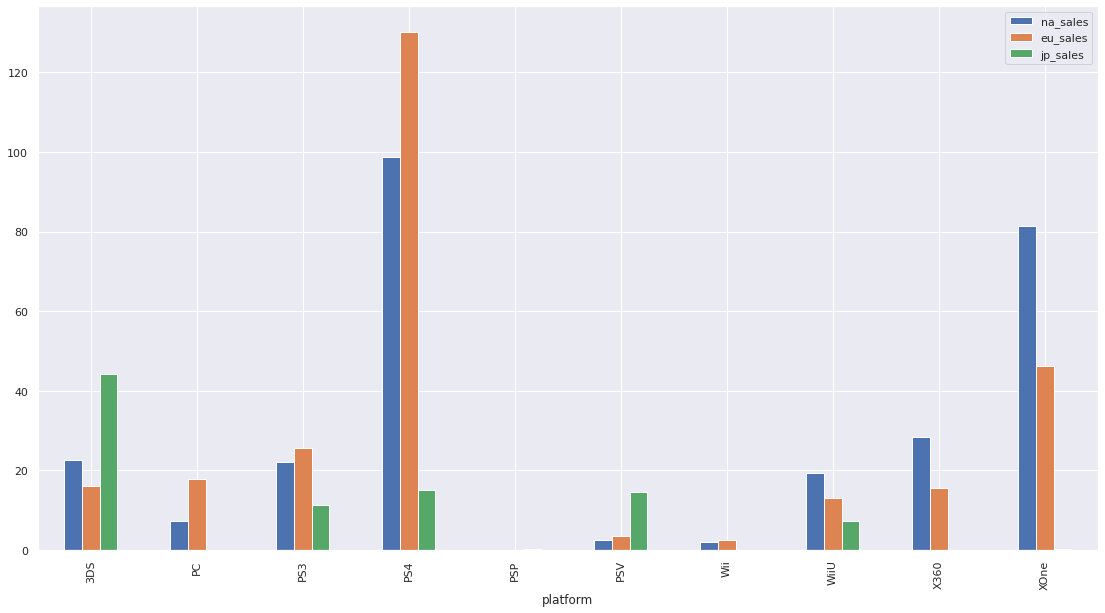

In [71]:
pivot.plot.bar();

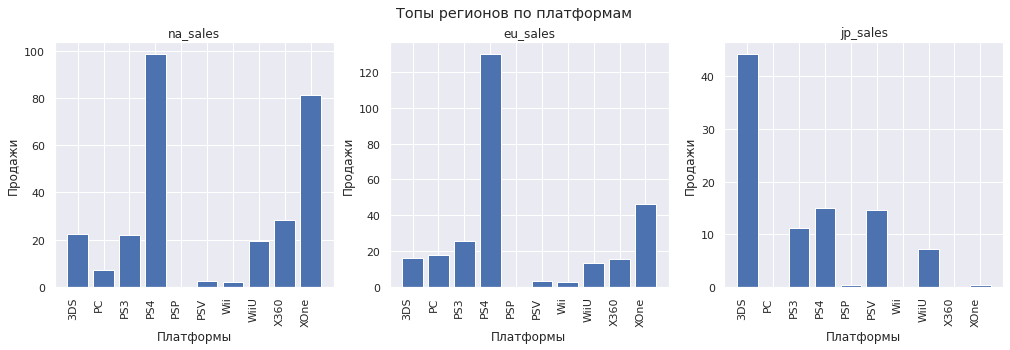

In [72]:
f, axs = plt.subplots(1,3, figsize=(17, 5))
f.autofmt_xdate(rotation=90)


axs[0].bar(x=pivot.index, height=pivot['na_sales'])
axs[0].grid(True)
axs[0].set_title('na_sales')
axs[0].set_xlabel('Платформы')
axs[0].set_ylabel('Продажи')


axs[1].bar(x=pivot.index, height=pivot['eu_sales'])
axs[1].grid(True)
axs[1].set_title('eu_sales')
axs[1].set_xlabel('Платформы')
axs[1].set_ylabel('Продажи')

axs[2].bar(x=pivot.index, height=pivot['jp_sales'])
axs[2].grid(True)
axs[2].set_title('jp_sales')
axs[2].set_xlabel('Платформы')
axs[2].set_ylabel('Продажи')

plt.suptitle('Топы регионов по платформам');

***Портреты***(топ платформ)***:***

*NA*
1) PS4 2) XOne 3) X360 4) 3DS 5) PS3

*EU*
1) PS4 2) XOne 3) PS3 4) PC 5) 3DS

*JP*
1) 3DS 2) PS4 3) PSV 4) PS3 5) WiiU


Япония - родина PlayStation и Nintendo и своих производителей они любят. Стоит отметить, что в топ попала портативная PSV. Если рекламировать игры для нее, то точно в Японии и Азии в целом.

В Европе и Америке топ довольно консервативные. Актуальное и "доживающее" поколения Xbox и PlayStation и портативная 3DS. X360 попала в shortlist NA игроков скорее всего из-за того, что Xbox там локальный бренд и за счет этого более популярный.

## Влияние рейтинга ESRB на продажи

Учитывая, что у нас есть только рейтинг ESRB, а он создан и используется только на рынках Северной Америки (США, Канада) оценить влияние сможем только на NA-рынок и (с большой натяжкой) на общемировые продажи. В Европе и Японии пусть и схожие, но свои системы оценок.

In [73]:
pivot = df_.groupby('rating').agg('mean')
pivot[['na_sales','world_sales']]

,na_sales,world_sales
rating,,
E,0.231689,0.607900
E10+,0.179622,0.387459
M,0.363849,0.854868
RP,0.086409,0.265648
T,0.143727,0.365793


- Самой большой популярностью пользуются игры с взрослым рейтингом M. Это можно связать с предпочтениями игроков жанров Action, Shooter и Fighting. Для большей реалистичности, зрелищности нередко используются такие выразительные средства, на которые детям и подросткам лучше не смотреть. 
 - Также это может говорить о популярности видеоигр среди взрослых. Они уже давно не только забава для детей, но и признанные спортивные дисциплины и искуство, за которое можно и премию BAFTA получить.
- На втором месте игры с рейтингом E (everyone). Т.е. никаких ограничений на их распространение и продажу нет. Тут же различные игры "для самых маленьких". Как развивающие или обучающие так и огромное количество игр по приключениям героев из популярных детских тв-програм, мультфильмов.
- К "средним" рейтингам E10+ и T (everyone 10+, Teen) продажи заметно сокращаются. Даже в сумме не дотягивают до продаж M-игр.

Если говорить о зависимости, то могу сформулировать так:

Если девелоперы и издатели игры не боятся затрагивать "взрослые" темы и по-максимуму используют доступные выразительные средства (в том числе мат, отображение крови и т.д.) есть неплохие шансы попасть в топы.

In [74]:
# check
pivot = df_.groupby('rating').agg('sum')
pivot

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,world_sales
rating,,,,,,,,
E,441285,50.74,58.06,8.94,15.39,10199,1111.0,133.13
E10+,372741,33.23,26.16,4.46,7.83,8372,969.7,71.68
M,533937,96.42,93.44,8.01,28.67,16393,1742.3,226.54
RP,1509221,64.72,58.95,56.90,18.40,1323,-459.2,198.97
T,546072,38.95,34.07,14.78,11.33,14658,1716.9,99.13


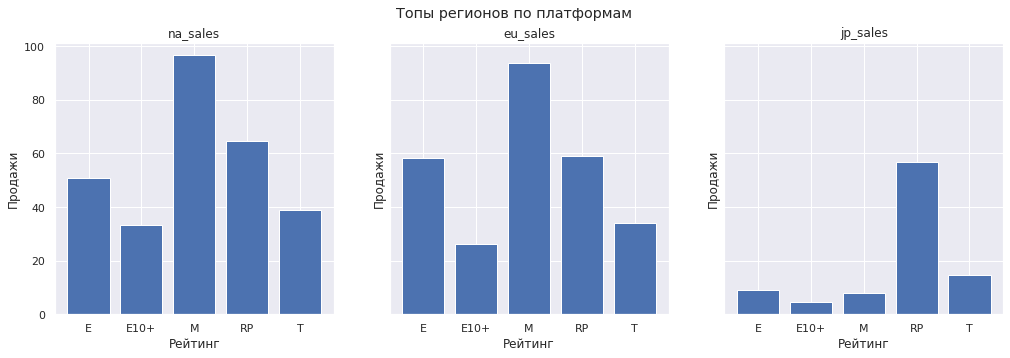

In [75]:
f, axs = plt.subplots(1,3, figsize=(17, 5), sharey=True)
#f.autofmt_xdate(rotation=90)


axs[0].bar(x=pivot.index, height=pivot['na_sales'])
axs[0].grid(True)
axs[0].set_title('na_sales')
axs[0].set_xlabel('Рейтинг')
axs[0].set_ylabel('Продажи')


axs[1].bar(x=pivot.index, height=pivot['eu_sales'])
axs[1].grid(True)
axs[1].set_title('eu_sales')
axs[1].set_xlabel('Рейтинг')
axs[1].set_ylabel('Продажи')

axs[2].bar(x=pivot.index, height=pivot['jp_sales'])
axs[2].grid(True)
axs[2].set_title('jp_sales')
axs[2].set_xlabel('Рейтинг')
axs[2].set_ylabel('Продажи')

plt.suptitle('Топы регионов по платформам');

## Гипотезы
### Гипотеза №1

**Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

In [76]:
df_xone = df_.query('platform == "XOne" and user_score >= 0')
df_xone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 165 to 16658
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             165 non-null    object 
 1   platform         165 non-null    object 
 2   year_of_release  165 non-null    int64  
 3   genre            165 non-null    object 
 4   na_sales         165 non-null    float64
 5   eu_sales         165 non-null    float64
 6   jp_sales         165 non-null    float64
 7   other_sales      165 non-null    float64
 8   critic_score     165 non-null    int64  
 9   user_score       165 non-null    float64
 10  rating           165 non-null    object 
 11  world_sales      165 non-null    float64
dtypes: float64(6), int64(2), object(4)
memory usage: 16.8+ KB


In [77]:
df_pc = df_.query('platform == "PC" and user_score >= 0')
df_pc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122 entries, 458 to 16690
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             122 non-null    object 
 1   platform         122 non-null    object 
 2   year_of_release  122 non-null    int64  
 3   genre            122 non-null    object 
 4   na_sales         122 non-null    float64
 5   eu_sales         122 non-null    float64
 6   jp_sales         122 non-null    float64
 7   other_sales      122 non-null    float64
 8   critic_score     122 non-null    int64  
 9   user_score       122 non-null    float64
 10  rating           122 non-null    object 
 11  world_sales      122 non-null    float64
dtypes: float64(6), int64(2), object(4)
memory usage: 12.4+ KB


**Вводные**
- Датасет у нас один, но срезы с оценками по платформам можно принять за отдельные генеральные совокупности. Поэтому используем ttest_ind (равенство средних двух генеральных совокупностей)
- Помня, что пропуски и значения `tbd` были заменены на -1 к срезу добавляем условие >=0 чтобы избавиться от возможных искажений
- Данных в срезах достаточно, значения одного порядка для того, чтобы не приводить их к одному размеру
- Пороговым значением возьмем 0,05

**Гипотезы для теста**

- *нулевая* - средние рейтинги равны
- *альтернативная* - не равны

In [78]:
xone = df_xone['user_score']
pc = df_pc['user_score']

alpha = .05

results = st.ttest_ind(
    xone, 
    pc)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


### Гипотеза №2

**Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.**

**Вводные**
- Датасет у нас один, но срезы с оценками по платформам можно принять за отдельные генеральные совокупности. Поэтому используем ttest_ind (равенство средних двух генеральных совокупностей)
- Помня, что пропуски и значения `tbd` были заменены на 0 к срезу добавляем условие >0 чтобы избавиться от возможных искажений
- Данных в срезах достаточно, значения одного порядка для того, чтобы не приводить их к одному размеру
- Пороговым значением возьмем 0,05

**Гипотезы для теста**

- *нулевая* - средние рейтинги равны
- *альтернативная* - не равны

In [80]:
df_act = df_.query('genre == "Action" and user_score > 0')
df_act.user_score.describe()

count    297.000000
mean       6.760606
std        1.377852
min        2.000000
25%        6.100000
50%        7.100000
75%        7.700000
max        9.000000
Name: user_score, dtype: float64

In [81]:
df_act.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 42 to 16690
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             297 non-null    object 
 1   platform         297 non-null    object 
 2   year_of_release  297 non-null    int64  
 3   genre            297 non-null    object 
 4   na_sales         297 non-null    float64
 5   eu_sales         297 non-null    float64
 6   jp_sales         297 non-null    float64
 7   other_sales      297 non-null    float64
 8   critic_score     297 non-null    int64  
 9   user_score       297 non-null    float64
 10  rating           297 non-null    object 
 11  world_sales      297 non-null    float64
dtypes: float64(6), int64(2), object(4)
memory usage: 30.2+ KB


In [82]:
df_spt = df_.query('genre == "Sports" and user_score > 0')
df_spt.user_score.describe()

count    127.000000
mean       5.225197
std        1.856604
min        0.200000
25%        4.000000
50%        5.500000
75%        6.650000
max        8.800000
Name: user_score, dtype: float64

In [83]:
df_spt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 77 to 16641
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             127 non-null    object 
 1   platform         127 non-null    object 
 2   year_of_release  127 non-null    int64  
 3   genre            127 non-null    object 
 4   na_sales         127 non-null    float64
 5   eu_sales         127 non-null    float64
 6   jp_sales         127 non-null    float64
 7   other_sales      127 non-null    float64
 8   critic_score     127 non-null    int64  
 9   user_score       127 non-null    float64
 10  rating           127 non-null    object 
 11  world_sales      127 non-null    float64
dtypes: float64(6), int64(2), object(4)
memory usage: 12.9+ KB


In [84]:
df_spt[df_spt['user_score'] < 2]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
5009,FIFA 17,X360,2016,Sports,0.07,0.28,0.0,0.03,-1,1.7,E,0.38
5165,NHL 15,PS3,2014,Sports,0.21,0.09,0.0,0.06,-1,1.6,E10+,0.36
7478,Tony Hawk's Pro Skater 5,PS4,2015,Sports,0.09,0.08,0.0,0.03,32,1.5,T,0.20
8264,Madden NFL 17,X360,2016,Sports,0.14,0.02,0.0,0.02,-1,0.7,E,0.18
9969,Madden NFL 17,PS3,2016,Sports,0.07,0.02,0.0,0.02,-1,0.2,E,0.11
12755,Rugby World Cup 2015,PS4,2015,Sports,0.00,0.05,0.0,0.01,25,1.9,E,0.06
16516,Rugby World Cup 2015,PC,2015,Sports,0.00,0.01,0.0,0.00,-1,1.4,E,0.01


In [85]:
action = df_act['user_score']
sports = df_spt['user_score']

alpha = .05

results = st.ttest_ind(
    action, 
    sports)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


### Вывод

Средние рейтинги не зависят от платформ, зато зависят от жанра. Возможно потому что спортивные игры часто серийные и разочарование от не оправдавшей ожиданий любимой игры сильнее.

## Выводы

- Популярные платформы ***живут*** 10-12 лет и остаются популярными (большое кол-во релизов) в течение 8-10 лет (за тафталогию извини)
 - ***Начиная с 2-3 и по 6-8 год жизни платформы продажи на популярных максимальны***

- Самыми плодовитыми за время жизни (что тоже может говорить о популярности) платформами являются DS, 3DS, GBA, PSP, PSV среди портативных и PlayStation (все поколения), Wii, Xbox (тоже все поколения, несмотря на просадку XOne) среди стационарных

- Подъемом индустрии можно считать период с 2006 по 2011 год. Тогда в течение года выходило более 1000 тайтлов.
- За подъемом следует заметный спад (более 30%)
- На момент составления датасета актуальными и популярными можно считать PS4, PSV, PC и XOne. (количество релизов растет, с учетом возможной неполноты данных за 2016 год) 

- Связи между оценками пользователей и продажами нет. А вот критики или очень хороши или действительно могут повлиять на продажи. Игры с рейтингом критиков больше 75 пунктов имеют шансы собрать большую кассу

- самые популярные жанры в миреэто Action, Shooter, Sports и Role-Playing (с оговоркой насчет JRPG для JP-игроков). Если и делать ставку то на игры этих жанров

***Портреты***(топ жанров)***:***

*NA*: 1) Shooter 2) Action 3) Sports 4) Role-Playing

*EU*: 1) Action 2) Shooter 3) Sports 4) Role-Playing

*JP*: 1) Role-Playing 2) Action 3) Fighting 4) Misc

***Портреты***(топ платформ)***:***

*NA*: 1) PS4 2) XOne 3) X360 4) 3DS 5) PS3

*EU*: 1) PS4 2) XOne 3) PS3 4) PC 5) 3DS

*JP*: 1) 3DS 2) PS4 3) PSV 4) PS3 5) WiiU


- Если девелоперы и издатели игры не боятся затрагивать "взрослые" темы и по-максимуму используют доступные выразительные средства (в том числе мат, отображение крови и т.д.) есть неплохие шансы попасть в топы.


### Summary

Если давать рекомендации для рекламных кампаний резюме будет следующее:

Европа/Америки:
- PS4, XOne или 3DS
- Action и Shooter c подростковым-взрослым рейтингом 
- Спортивные симуляторы или игры для детей

Япония
- PS4 3DS
- Ролевые игры, экшены и файтинги